In [1]:
from typing import List
import random

import torch
import torch.nn as nn
import tntorch as tn
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

%config InlineBackend.figure_format = "svg"

## TTMatrix and autograd

In [2]:
a = tn.TTMatrix(torch.rand(100, 50) / 10, ranks=[4], input_dims=[10, 10], output_dims=[10, 5])

In [3]:
b = torch.rand(200, 100)

In [4]:
c = b @ a.torch()
cc = tn.tt_multiply(a, b)
torch.allclose(c, cc)

True

By default cores don't require grad.

In [5]:
[core.requires_grad for core in a.cores], [core.is_leaf for core in a.cores]

([False, False], [True, True])

So let's turn them on.

In [6]:
a.cores = [core.requires_grad_() for core in a.cores]
[core.requires_grad for core in a.cores], [core.is_leaf for core in a.cores]

([True, True], [True, True])

_Note: if you try to create TTMatrix from tensor, which requires grad, cores won't be leaf tensors. So they won't keep `.grad` and we will not be able to optimize._

In [7]:
bad_a = tn.TTMatrix(torch.rand(100, 50, requires_grad=True) / 10, ranks=[4], input_dims=[10, 10], output_dims=[10, 5])
[core.requires_grad for core in bad_a.cores], [core.is_leaf for core in bad_a.cores]

([True, True], [False, False])

### SGD with TTMatrix

In [8]:
a = tn.TTMatrix(torch.rand(100, 50) / 10, ranks=[4], input_dims=[10, 10], output_dims=[10, 5])
a.cores = [core.requires_grad_() for core in a.cores]
b = torch.rand(1, 100)

In [9]:
def compute_loss(weight, target):
    return torch.sum(torch.square(tn.tt_multiply(weight, target)))

def sgd_step(weight, target, lr):
    loss = compute_loss(weight, target)
    loss.backward()
    
    with torch.no_grad():
        for core in weight.cores:
            core -= lr * core.grad
            core.grad.zero_()

    return loss.item()

def train_sgd(weight, target, lr, n_steps):
    losses = []

    for i in range(n_steps):
        loss = sgd_step(a, b, lr)
        losses.append(loss)

    return losses

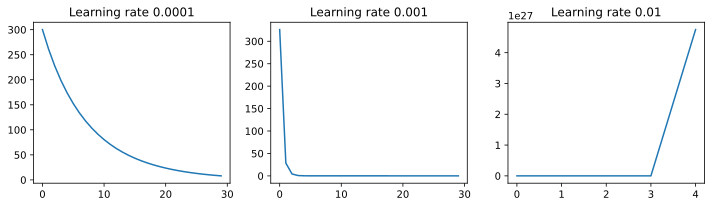

In [10]:
plt.figure(figsize=(10, 3))
for i, lr in enumerate((1e-4, 1e-3, 1e-2)):
    a = tn.TTMatrix(torch.rand(100, 50) / 10, ranks=[4], input_dims=[10, 10], output_dims=[10, 5])
    a.cores = [core.requires_grad_() for core in a.cores]
    b = torch.rand(1, 100)

    losses = train_sgd(a, b, lr, 30)
    
    plt.subplot(1, 3, i + 1)
    plt.plot(losses)
    plt.title(f"Learning rate {lr}")

plt.tight_layout()
plt.show()

For big learning rates optimization is unstable.

## Implement layer

In [53]:
import numpy as np
import torch
from torch import nn
import tntorch as tn

#import tensorly as tl
#from tensorly.decomposition import tensor_train
#tl.set_backend('pytorch')

import tntorch as tn



def matrix_to_tt_cores(matrix, shapes, ranks):
  shapes = np.asarray(shapes)
  matrix = matrix.reshape(list(shapes.flatten()))
  print (matrix.shape)
  d = len(shapes[0])
  transpose_idx = list(np.arange(2 * d).reshape(2, d).T.flatten())
  matrix = matrix.permute(*transpose_idx)
  print (matrix.shape)
  newshape = np.prod(shapes, 0)
  matrix = matrix.reshape(list(newshape))
  print (matrix.shape)
  #tt = tn.Tensor(matrix, ranks_tt=ranks)
  tt = tensor_train(full, rank = ranks)



  newcores = []
  for core, s1, s2, r1, r2 in zip(tt.cores,
                                  shapes[0], shapes[1],
                                  tt.ranks_tt, tt.ranks_tt[1:]):
    newcores.append(core.reshape((r1, s1, s2, r2)))
  return newcores


def ttmatmul(cores, t, shapes, ranks):
  ranks = [1] + ranks + [1]
  tshape = t.shape

  t = t.transpose(1, 0)
  t = t.reshape((-1, shapes[1][-1], 1))
  ndims = len(cores)
  for i in reversed(range(ndims)):
    t = torch.einsum('aijb,rjb->ira', (cores[i], t))
    if i:
      t = t.reshape((-1, shapes[1][i - 1], ranks[i]))
  t = t.reshape((int(np.prod(shapes[0])), tshape[1]))
  return t


def transpose(cores):
    result = []
    for c in cores:
        result.append(c.permute((0, 2, 1, 3)))
    return result


def matmultt(t, cores, shapes, ranks):
    #t = t.transpose(1, 0)
    #cores = transpose(cores)
    shapes = [shapes[1], shapes[0]]
    return ttmatmul(cores, t, shapes, ranks).transpose(1, 0)


def tt_multiply_tt_custom(cores: nn.ParameterList, vector : torch.Tensor, shapes, in_dims, ranks):
    """
    tensor: bs*768
    in_dims = [32, 24]
    """
    
    #print ("shapes, in_dims, ranks", shapes, in_dims, ranks)
    
    bs = vector.shape[0]
    seq_len = vector.shape[1]
    result = vector.reshape(bs*seq_len, in_dims[0], -1)
    core = cores[0].reshape(in_dims[0], cores[0].shape[2])
    result = torch.einsum('bid,ir->bdr', result, core)
    for i in range(1, len(cores)):
        if (i < len(in_dims)):
            result = result.reshape(-1, in_dims[i], cores[i].shape[0])
            core = cores[i].reshape(cores[i].shape[0], in_dims[i], -1, cores[i].shape[2])
            result = torch.einsum('bdr,rdac->bac', result, core)
        else:
            result = result.reshape(bs, -1, cores[i].shape[0])
            core = cores[i].reshape(cores[i].shape[0], -1, cores[i].shape[2])
            result = torch.einsum('bdr,rga->bdga', result, core)
    return result.reshape(bs, seq_len, -1)
            
    
class TTLayer(nn.Module):
    def __init__(self, layer, ranks, shapes, in_dims):
        super(TTLayer, self).__init__()
        self.ranks = ranks
        self.in_dims = in_dims
        self.shapes = shapes
        print ("layer.shape", layer.shape)
        with torch.no_grad():
            #weight = layer.weight.transpose(1, 0)
            self.cores = nn.ParameterList(
            map(nn.Parameter, tn.Tensor(layer.reshape(self.shapes), ranks_tt=ranks[1 : len(ranks)-1]).cores))
        #self.bias = layer.bias

    def forward(self, inputs):
        out = tt_multiply_tt_custom(self.cores, inputs, self.shapes, self.in_dims, self.ranks)
        out = out #+ self.bias
        return out


In [151]:
TT_SHAPES = [32, 48, 48, 32]
TT_RANKS = [1, 32, 390, 32, 1]

In [173]:
fc_w = torch.rand(3072, 768)
tntensor =tn.Tensor(fc_w.reshape(TT_SHAPES), ranks_tt = [32, 32, 32], verbose = True)
#model.cores = tntensor.cores

In [ ]:
fc_w = colbert.bert.encoder.layer[4].intermediate.dense.weight

In [172]:
tmmatrix = tn.TTMatrix(fc_w, [32], [64, 48], [24, 32])

TypeError: __init__() got an unexpected keyword argument 'verbose'

In [170]:
for elem in tmmatrix.cores:
    print (elem.shape)
    print (torch.max(elem))

torch.Size([1, 64, 24, 32])
tensor(2.3069)
torch.Size([32, 48, 32, 1])
tensor(0.1010)


In [174]:
for elem in tntensor.cores:
    print (elem.shape)
    print (torch.max(elem))

torch.Size([1, 32, 32])
tensor(10.6620)
torch.Size([32, 48, 32])
tensor(0.1089)
torch.Size([32, 48, 32])
tensor(0.1451)
torch.Size([32, 32, 1])
tensor(0.5381)


In [ ]:
tn.Tensor(layer.reshape(self.shapes), ranks_tt=ranks[1 : len(ranks)-1]).cores)

In [160]:
predict = model(torch.rand(2, 5, 3072))
#predict = torch.nn.functional.normalize(predict)
torch.max(predict)

tensor(803.1353, grad_fn=<MaxBackward1>)

In [127]:
[p.shape for p in model.parameters()]

[torch.Size([1, 32, 32]),
 torch.Size([32, 48, 390]),
 torch.Size([390, 48, 32]),
 torch.Size([32, 32, 1])]

### Test training

In [139]:
#opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [140]:
dataset = torch.rand(20, 5, 3072)
target = torch.rand(20, 768)

In [161]:
for elem in model.cores:
    print (elem.shape)
    print (torch.max(elem))

torch.Size([1, 32, 32])
tensor(32.9765, grad_fn=<MaxBackward1>)
torch.Size([32, 48, 390])
tensor(0.0367, grad_fn=<MaxBackward1>)
torch.Size([390, 48, 32])
tensor(0.1453, grad_fn=<MaxBackward1>)
torch.Size([32, 32, 1])
tensor(0.4969, grad_fn=<MaxBackward1>)


In [155]:
def train_one_epoch(dataset, target, model, opt, criterion):
    losses = []

    for step, (x, y) in enumerate(zip(dataset, target)):
        opt.zero_grad()
        predict = model(x.unsqueeze(0))
        loss = criterion(predict, y)
        assert not torch.isnan(loss).any(), f"Nan at step {step}"
        loss.backward()
        opt.step()

        losses.append(loss.item())
    return losses

def train(dataset, target, model, opt, criterion, n_epochs):
    losses = []
    for epoch in range(n_epochs):
        epoch_losses = train_one_epoch(dataset, target, model, opt, criterion)
        losses.extend(epoch_losses)
    return losses

In [156]:
losses = train(dataset, target, model, opt, criterion, n_epochs=10)


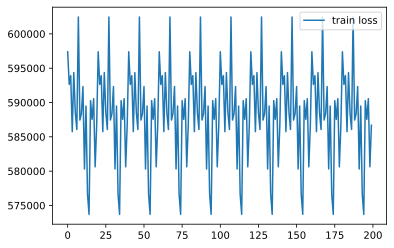

In [157]:
plt.plot(losses, label="train loss")
plt.legend()
plt.show()

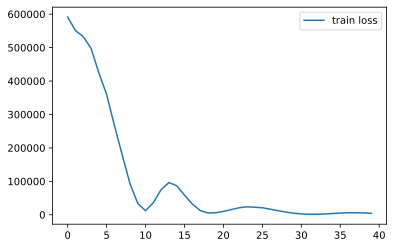

In [134]:
plt.plot(losses[:40], label="train loss")
plt.legend()
plt.show()

### Test init from full linear

tensor(1.1074, grad_fn=<MaxBackward1>)


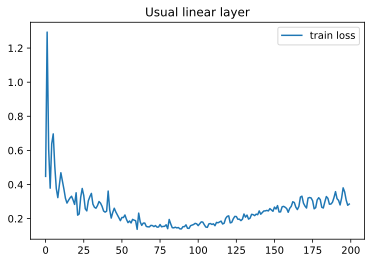

In [143]:
pretrained_model = nn.Linear(3072, 768, bias=False)
pretrained_model.weights = torch.rand(3072, 768)

predict = pretrained_model(torch.rand(2, 5, 3072))
print (torch.max(predict))
opt = torch.optim.Adam(pretrained_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

losses = train(dataset, target, pretrained_model, opt, criterion, n_epochs=10)

plt.title("Usual linear layer")
plt.plot(losses, label="train loss")
plt.legend()
plt.show()

In [102]:
pretrained_model = nn.Linear(3072, 768, bias=False)
pretrained_model.weights = torch.rand(3072, 768)
model = TTLayer(pretrained_model.weights, shapes = TT_SHAPES, in_dims = [32, 48, 2], ranks = TT_RANKS)

layer.shape torch.Size([3072, 768])


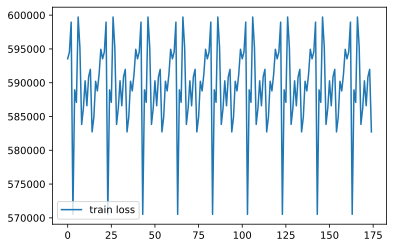

In [103]:
losses = train(dataset, target, model, opt, criterion, n_epochs=10)

plt.plot(losses, label="train loss")
plt.legend()
plt.show()

i tensor(0.3029, grad_fn=<MseLossBackward0>)
i tensor(0.3648, grad_fn=<MseLossBackward0>)
i tensor(0.4408, grad_fn=<MseLossBackward0>)
i tensor(0.4695, grad_fn=<MseLossBackward0>)
i tensor(0.4596, grad_fn=<MseLossBackward0>)
i tensor(0.4223, grad_fn=<MseLossBackward0>)
i tensor(0.3822, grad_fn=<MseLossBackward0>)
i tensor(0.3598, grad_fn=<MseLossBackward0>)
i tensor(0.3367, grad_fn=<MseLossBackward0>)
i tensor(0.3819, grad_fn=<MseLossBackward0>)
i tensor(0.4389, grad_fn=<MseLossBackward0>)
i tensor(0.5060, grad_fn=<MseLossBackward0>)
i tensor(0.5602, grad_fn=<MseLossBackward0>)
i tensor(0.5414, grad_fn=<MseLossBackward0>)
i tensor(0.5120, grad_fn=<MseLossBackward0>)
i tensor(0.4228, grad_fn=<MseLossBackward0>)
i tensor(0.3216, grad_fn=<MseLossBackward0>)
i tensor(0.2403, grad_fn=<MseLossBackward0>)
i tensor(0.2101, grad_fn=<MseLossBackward0>)
i tensor(0.2307, grad_fn=<MseLossBackward0>)


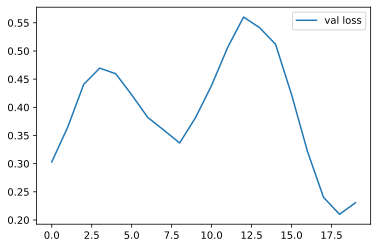

In [98]:
losses = []

for step, (x, y) in enumerate(zip(dataset, target)):
    opt.zero_grad()
    predict = pretrained_model(x.unsqueeze(0))
    loss = criterion(predict, y)
    print ("i", loss)
    assert not torch.isnan(loss).any(), f"Nan at step {step}"
    #loss.backward()
    #opt.step()
    losses.append(loss)

plt.plot(losses, label="val loss")
plt.legend()
plt.show()


In [99]:
model = TTLayer(pretrained_model.weight, shapes = TT_SHAPES, in_dims = [32, 48, 2], ranks = TT_RANKS)

layer.shape torch.Size([768, 3072])


i tensor(0.2131, grad_fn=<MseLossBackward0>)
i tensor(0.2053, grad_fn=<MseLossBackward0>)
i tensor(0.2029, grad_fn=<MseLossBackward0>)
i tensor(0.2142, grad_fn=<MseLossBackward0>)
i tensor(0.2183, grad_fn=<MseLossBackward0>)
i tensor(0.2105, grad_fn=<MseLossBackward0>)
i tensor(0.2010, grad_fn=<MseLossBackward0>)
i tensor(0.2151, grad_fn=<MseLossBackward0>)
i tensor(0.2059, grad_fn=<MseLossBackward0>)
i tensor(0.2065, grad_fn=<MseLossBackward0>)
i tensor(0.2106, grad_fn=<MseLossBackward0>)
i tensor(0.2111, grad_fn=<MseLossBackward0>)
i tensor(0.2105, grad_fn=<MseLossBackward0>)
i tensor(0.2139, grad_fn=<MseLossBackward0>)
i tensor(0.2008, grad_fn=<MseLossBackward0>)
i tensor(0.1946, grad_fn=<MseLossBackward0>)
i tensor(0.1961, grad_fn=<MseLossBackward0>)
i tensor(0.2053, grad_fn=<MseLossBackward0>)
i tensor(0.2086, grad_fn=<MseLossBackward0>)
i tensor(0.2168, grad_fn=<MseLossBackward0>)


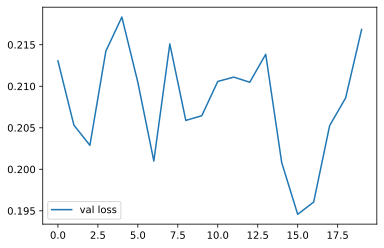

In [100]:
losses = []

for step, (x, y) in enumerate(zip(dataset, target)):
    opt.zero_grad()
    predict = model(x.unsqueeze(0))
    loss = criterion(predict, y)
    print ("i", loss)
    assert not torch.isnan(loss).any(), f"Nan at step {step}"
    #loss.backward()
    #opt.step()
    losses.append(loss)

plt.plot(losses, label="val loss")
plt.legend()
plt.show()

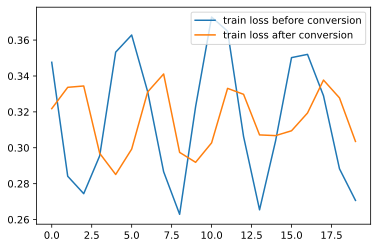

In [86]:
plt.plot(losses[-dataset.shape[0]:], label="train loss before conversion")

losses = train_one_epoch(dataset, target, pretrained_model, opt, criterion)

plt.plot(losses, label="train loss after conversion")
plt.legend()
plt.show()

## Bigger models

In [21]:
model = nn.Sequential(
    TTLinear(100, 80, [8], [10, 10], [10, 8]),
    nn.ReLU(),
    TTLinear(80, 50, [8], [10, 8], [10, 5]),
)

print("Parameter count:", sum(p.numel() for p in model.parameters()))

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
losses = train(dataset, target, model, opt, criterion, n_epochs=10)

Parameter count: 2690


In [22]:
usual_model = nn.Sequential(
    nn.Linear(100, 80),
    nn.ReLU(),
    nn.Linear(80, 50),
)

print("Parameter count:", sum(p.numel() for p in usual_model.parameters()))

opt = torch.optim.Adam(usual_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
usual_losses = train(dataset, target, usual_model, opt, criterion, n_epochs=10)

Parameter count: 12130


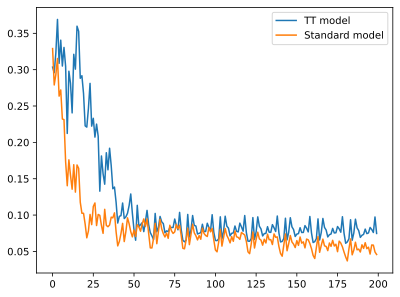

In [23]:
plt.plot(losses, label="TT model")
plt.plot(usual_losses, label="Standard model")
plt.legend()
plt.show()

In [145]:
class TTLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int, ranks: List[int], input_dims: List[int], 
                 output_dims: List[int], bias: bool = True, device=None, dtype=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.ranks = ranks
        self.input_dims = input_dims
        self.output_dims = output_dims

        # Initialize weights from uniform[-1 / sqrt(in_features), 1 / sqrt(in_features)]
        factory_kwargs = {"device": device, "dtype": dtype}
        init = torch.rand(in_features, out_features, **factory_kwargs)
        init = (2 * init - 1) / np.sqrt(in_features)
        self.weight = tn.TTMatrix(init, ranks, input_dims, output_dims)
        
        # torch doesn't recognize attributes of self.weight as parameters,
        # so we have to specify them
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

        if bias:
            init = torch.rand(out_features, **factory_kwargs)
            init = (2 * init - 1) / np.sqrt(out_features)
            self.bias = nn.Parameter(init)
        else:
            self.register_parameter('bias', None)


    def forward(self, x: torch.Tensor):
        res = tn.tt_multiply(self.weight, x)
        if self.bias is not None:
            res += self.bias
        return res

    def set_weight(self, new_weights: torch.Tensor):
        # in regular linear layer weights are transposed, so we transpose back
        new_weights = new_weights.clone().detach().T

        shape = torch.Size((self.in_features, self.out_features))
        assert new_weights.shape == shape, f"Expected shape {shape}, got {new_weights.shape}"

        self.weight = tn.TTMatrix(new_weights, self.ranks, self.input_dims, self.output_dims)
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

    def set_from_linear(self, linear: nn.Linear):
        self.set_weight(linear.weight.data)
        self.bias = linear.bias.data.clone() if linear.bias is not None else None


In [146]:
model = TTLinear(100, 50, [4], [10, 10], [10, 5], bias=False)

In [150]:
for elem in model.cores:
    print (elem.shape)
    print (torch.max(elem))

torch.Size([1, 10, 10, 4])
tensor(0.2480, grad_fn=<MaxBackward1>)
torch.Size([4, 10, 5, 1])
tensor(0.4082, grad_fn=<MaxBackward1>)


In [148]:
pretrained_model = nn.Linear(100, 50, bias=False)

In [149]:
model.set_from_linear(pretrained_model)